# Initialize and Train CGCNN

Automatically search for an NVIDIA GPU and use it. If not, then use CPU

In [1]:
import torch


if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU')
else:
    device = 'cpu'
    print('Using CPU')

Using GPU


Load all of our preprocessed and split data from our cache

In [2]:
import pickle


with open('../preprocessing/sdt/feature_dimensions.pkl', 'rb') as file_handle:
    orig_atom_fea_len, nbr_fea_len = pickle.load(file_handle)

with open('../preprocessing/splits.pkl', 'rb') as file_handle:
    splits = pickle.load(file_handle)

sdts_train, sdts_val = splits['sdts_train'], splits['sdts_val']
targets_train, targets_val = splits['targets_train'], splits['targets_val']

Initialize the CGCNN `net` class

In [3]:
from torch.optim import Adam
import torch
import skorch.callbacks.base
from skorch import callbacks  # needs skorch >= 0.4  
from skorch import NeuralNetRegressor
from skorch.dataset import CVSplit
from cgcnn.model import CrystalGraphConvNet
from cgcnn.data import collate_pool, MergeDataset


# Callback to checkpoint parameters every time there is a new best for validation loss
cp = callbacks.Checkpoint(monitor='valid_loss_best', fn_prefix='valid_best_')

# Callback to load the checkpoint with the best validation loss at the end of training
class train_end_load_best_valid_loss(callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('valid_best_params.pt')
load_best_valid_loss = train_end_load_best_valid_loss()

# Callback to set the learning rate dynamically
LR_schedule = callbacks.lr_scheduler.LRScheduler('MultiStepLR', milestones=[100], gamma=0.1)

net = NeuralNetRegressor(
    CrystalGraphConvNet,
    # --
    module__orig_atom_fea_len=orig_atom_fea_len,
    module__nbr_fea_len=nbr_fea_len,
#     module__orig_atom_fea_len=98,
#     module__nbr_fea_len=6,
    # --
    batch_size=214,
    module__classification=False,
    lr=0.0056,
    max_epochs=150,
    module__atom_fea_len=46,
    module__h_fea_len=83,
    module__n_conv=8,
    module__n_h=4,
    optimizer=Adam,
    iterator_train__pin_memory=True,
    iterator_train__num_workers=0,
    iterator_train__collate_fn=collate_pool,
    iterator_train__shuffle=True,
    iterator_valid__pin_memory=True,
    iterator_valid__num_workers=0,
    iterator_valid__collate_fn=collate_pool,
    iterator_valid__shuffle=False,
    device=device,
    criterion=torch.nn.L1Loss,
    # --
    dataset=MergeDataset,
    # --
    callbacks=[cp, load_best_valid_loss, LR_schedule]
)

Training the CGCNN

In [6]:
net.initialize()
net.fit(sdts_train, targets_train)

Re-initializing module because the following parameters were re-set: atom_fea_len, classification, h_fea_len, n_conv, n_h, nbr_fea_len, orig_atom_fea_len.
Re-initializing optimizer.
  epoch    train_loss    valid_loss    cp      dur
-------  ------------  ------------  ----  -------
      1        0.3924        0.3439     +  15.9217
      2        0.3103        0.5873        14.2488
      3        0.2696        0.2364     +  13.9120
      4        0.2644        0.2318     +  13.9862
      5        0.2475        0.3749        13.9882
      6        0.2702        0.2461        13.9740
      7        0.2181        0.2071     +  13.7197
      8        0.2507        0.2120        14.2931
      9        0.2633        0.2000     +  13.8609
     10        0.2487        0.2069        13.8518
     11        0.2334        0.2226        13.9998
     12        0.2349        0.2208        13.9329
     13        0.2117        0.1994     +  14.5149
     14        0.2536        0.2239        13.8990
  

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=CrystalGraphConvNet(
    (embedding): Linear(in_features=98, out_features=46, bias=True)
    (convs): ModuleList(
      (0): ConvLayer(
        (fc_full): Linear(in_features=98, out_features=92, bias=True)
        (sigmoid): Sigmoid()
        (softplus1): Softplus(beta=1, threshold=20)
        (bn1): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (softplus2): Softplus(beta=1, threshold=20)
      )
      (1): ConvLayer(
        (fc_full): Linear(in_features=98, out_features=92, bias=True)
        (sigmoid): Sigmoid()
        (softplus1): Softplus(beta=1, threshold=20)
        (bn1): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (softplus2): Softplus(

...or load whatever is cached

In [5]:
net.initialize()
net.load_params(f_history='valid_best_history.json',
                f_optimizer= 'valid_best_optimizer.pt', 
                f_params='valid_best_params.pt')

Re-initializing module because the following parameters were re-set: atom_fea_len, classification, h_fea_len, n_conv, n_h, nbr_fea_len, orig_atom_fea_len.
Re-initializing optimizer.


# Initialize and Train GP-matern with CGCNN Mean

In [6]:
%matplotlib inline
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns


# Get CGCNN predictions on sdts_val, and sdts_train
targets_pred = net.predict(sdts_val).reshape(-1)
targets_pred_train = net.predict(sdts_train).reshape(-1)

In [7]:
# Load fingerprints data
fingerprints_train_raw = splits['fingerprints_train']
fingerprints_val_raw = splits['fingerprints_val']

In [8]:
from sklearn.preprocessing import StandardScaler
import torch


# Scale the fingerprints
scaler = StandardScaler()
fingerprints_train = scaler.fit_transform(fingerprints_train_raw)
fingerprints_val = scaler.transform(fingerprints_val_raw)

# Make torch.Tensor version of data for GPyTorch
fingerprints_train = torch.Tensor(fingerprints_train).contiguous()
fingerprints_val = torch.Tensor(fingerprints_val)
targets_train_gp = torch.Tensor(targets_train.reshape(-1))
targets_val_gp = torch.Tensor(targets_val.reshape(-1))

# Transform targets for GP with nonzero mean
targets_train_gp = targets_train_gp - torch.Tensor(targets_pred_train)
targets_val_gp = targets_val_gp - torch.Tensor(targets_pred)

In [26]:
import gpytorch


# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
#         self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

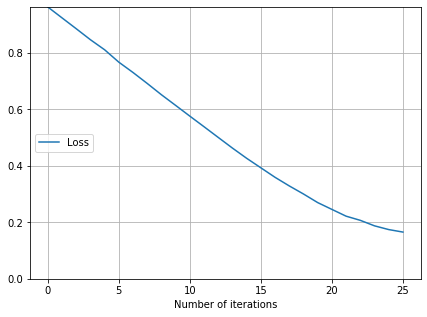

CPU times: user 1min 48s, sys: 50.6 s, total: 2min 38s
Wall time: 2min 38s


In [27]:
# Training the GP

%matplotlib inline
from collections import defaultdict
from matplotlib import pyplot as plt
from IPython.display import clear_output


# Initialize the model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(fingerprints_train, targets_train_gp, likelihood)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Function to make dynamic learning curve
def live_plot(data_dict, figsize=(7, 5), title=''):
    ''' Credit to Ziofil on StackOverflow '''
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label, data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('Number of iterations')
    plt.legend(loc='center left')  # the plot evolves to the right
    ax = plt.gca()
    ax.set_ylim(0, max(max(data) for data in data_dict.values()))
    plt.show()

def train(training_iterations=25):
    # Train the model
    learning_curve_data = defaultdict(list)
    for i in range(training_iterations):
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(fingerprints_train)
        # Calc loss and backprop derivatives
        loss = -mll(output, targets_train_gp)
        loss.backward()
        # Update the learning curve
        learning_curve_data['Loss'].append(loss.item())
        live_plot(learning_curve_data)
        optimizer.step()

%time train(26)

# Assess Performance: GP-matern with CGCNN Mean in Transformed Output Space

In [28]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make the predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = model(fingerprints_val)

MAE = 0.18 eV
RMSE = 0.35 eV
R^2 = 0.07


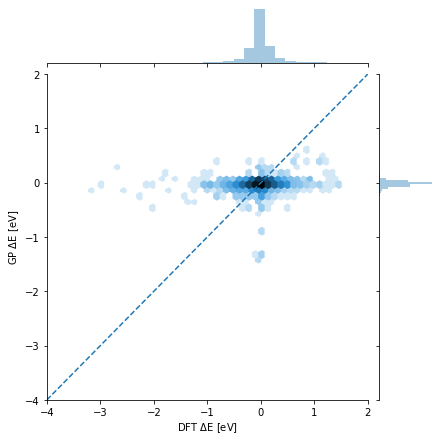

In [29]:
# Plotting results (transformed output space)

# Parse the predictions
targets_pred_gp = preds.mean
mae = mean_absolute_error(targets_val_gp, targets_pred_gp)
rmse = np.sqrt(mean_squared_error(targets_val_gp, targets_pred_gp))
r2 = r2_score(targets_val_gp, targets_pred_gp)

# Report
print('MAE = %.2f eV' % mae)
print('RMSE = %.2f eV' % rmse)
print('R^2 = %.2f' % r2)

# Plot
grid = sns.jointplot(targets_val_gp, targets_pred_gp,
                     kind='hex',
                     bins='log',
                     extent=[-4, 2, -4, 2])
_ = grid.ax_joint.set_xlim([-4, 2])
_ = grid.ax_joint.set_ylim([-4, 2])
_ = grid.ax_joint.plot([-4, 2], [-4, 2], '--')
_ = grid.ax_joint.set_xlabel('DFT $\Delta$E [eV]')
_ = grid.ax_joint.set_ylabel('GP $\Delta$E [eV]')

# Assess Performance: GP-matern with CGCNN Mean in Original Output Space

MAE = 0.18 eV
RMSE = 0.35 eV
R^2 = 0.74


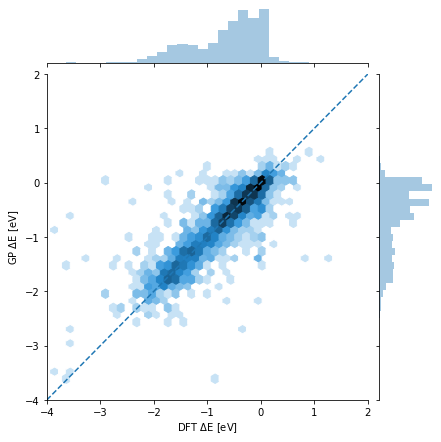

In [30]:
# Plotting results (original output space)

# Transform outputs
targets_val_gp_orig = targets_val_gp + torch.Tensor(targets_pred)
targets_pred_gp_orig = targets_pred_gp + torch.Tensor(targets_pred)

# Parse the predictions
mae = mean_absolute_error(targets_val_gp_orig, targets_pred_gp_orig)
rmse = np.sqrt(mean_squared_error(targets_val_gp_orig, targets_pred_gp_orig))
r2 = r2_score(targets_val_gp_orig, targets_pred_gp_orig)

# Report
print('MAE = %.2f eV' % mae)
print('RMSE = %.2f eV' % rmse)
print('R^2 = %.2f' % r2)

# Plot
grid = sns.jointplot(targets_val_gp_orig, targets_pred_gp_orig,
                     kind='hex',
                     bins='log',
                     extent=[-4, 2, -4, 2])
_ = grid.ax_joint.set_xlim([-4, 2])
_ = grid.ax_joint.set_ylim([-4, 2])
_ = grid.ax_joint.plot([-4, 2], [-4, 2], '--')
_ = grid.ax_joint.set_xlabel('DFT $\Delta$E [eV]')
_ = grid.ax_joint.set_ylabel('GP $\Delta$E [eV]')

In [31]:
# Calibration

import numpy as np
from scipy import stats
from tqdm import tqdm_notebook


residuals = (targets_pred_gp_orig - targets_val_gp_orig).detach().numpy()
standard_errors = preds.stddev.detach().numpy() # TODO: confirm we don't need to transform preds stds to orig space.

standard_errors = standard_errors * 1.2

def calculate_density(percentile):
    num_within_quantile = 0
    for se, resid in zip(standard_errors, residuals):
        norm = stats.norm(loc=0, scale=se)
        lower_bound = norm.ppf(0.5-percentile/2)
        upper_bound = norm.ppf(0.5+percentile/2)
        if lower_bound <= resid <= upper_bound:
            num_within_quantile += 1
    density = num_within_quantile / len(residuals)
    return density

predicted_pi = np.linspace(0, 1, 20)
observed_pi = [calculate_density(quantile)
               for quantile in tqdm_notebook(predicted_pi, desc='Calibration')]

Calibration factor = 0.03
Sharpness = 0.21 eV


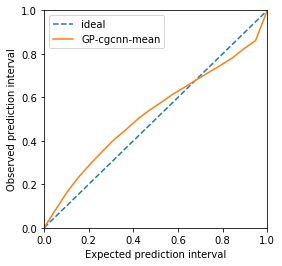

In [32]:
# Plotting Calibration

%matplotlib inline
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
import seaborn as sns


# Plot the calibration curve
fig = plt.figure(figsize=(4, 4))
ax_ideal = sns.lineplot([0, 1], [0, 1], label='ideal')
_ = ax_ideal.lines[0].set_linestyle('--')
ax_gp = sns.lineplot(predicted_pi, observed_pi, label='GP-cgcnn-mean')
_ = ax_gp.set_xlabel('Expected prediction interval')
_ = ax_gp.set_ylabel('Observed prediction interval')
_ = ax_gp.set_xlim([0, 1])
_ = ax_gp.set_ylim([0, 1])

# Report the calibration factor
actual_calibration_area = integrate.trapz(y=observed_pi, x=predicted_pi)
ideal_calibration_area = integrate.trapz(y=predicted_pi, x=predicted_pi)
calibration_factor = actual_calibration_area - ideal_calibration_area
print('Calibration factor = %.2f' % calibration_factor)

# Report sharpness
sharpness = np.sqrt(np.mean(standard_errors**2))
print('Sharpness = %.2f eV' % sharpness)